<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/AbstractPainting01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ES CLIP in JAX - Fitting Concrete Images

This Colab notebook is [JAX](https://github.com/google/jax) implementation of **Modern Evolution Strategies for Creativity: Fitting Concrete Images and Abstract Concepts** ([paper](https://arxiv.org/abs/2109.08857), [web](https://es-clip.github.io/), [original code](https://github.com/google/brain-tokyo-workshop/tree/master/es-clip) ).  It is the **Fitting Concrete Images** part.

This notebook is designed to leverage accelerators (GPUs/TPUs) and can scale well (almost linearly) with multiple accelerators thanks to JAX, so **(better multiple) accelerators are strongly encouraged**. Although it may still runs with a CPU backend, such enviroment would be extremely slow. To leverage accelerators, you could do **one** of following setting:

- **Using Colab's TPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'TPU' in the dropdown. Depending on your  Colab subscription, you may get 1-8 TPUs.
- **Using Colab's GPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'GPU' in the dropdown. Depending on your Colab subscription, you may get one GPU with in certain models.
- **Using a local runtime with multiple GPUs**. This is more envolving and needs some tweaking. The official [instructions](https://research.google.com/colaboratory/local-runtimes.html) may be helpful.

The output of in this notebook is from a running on a local runtime with 8 NVIDIA A100 GPUs.

In [ ]:
! nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB
NVIDIA A100-SXM4-40GB


## Import packages and define utilities

In [ ]:
import datetime
import functools
import pprint
import os
import sys

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from IPython.display import clear_output
import jax
from jax import lax
from jax import numpy as jnp
import numpy as np
from PIL import Image

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

try:
  import drawSvg
except ImportError:
  ! pip install drawSvg
  clear_output()
  import drawSvg

!pip install evojax
clear_output()

from evojax.algo.pgpe import PGPE

In [ ]:
# JAX based rendering

def quantitize(a, quant):
  return lax.cond(
    quant > 0, 
    lambda v: jnp.rint(v * quant) / quant,
    lambda v: v,
    a
  )

def put_triangle_fn(i_triangle, packed_args):
  canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant = packed_args
  n_batch, h, w = canvas.shape[:3]

  xy0_triangle = lax.dynamic_slice_in_dim(xy0, i_triangle, 1, axis=1)
  xy1_triangle = lax.dynamic_slice_in_dim(xy1, i_triangle, 1, axis=1)
  xy2_triangle = lax.dynamic_slice_in_dim(xy2, i_triangle, 1, axis=1)

  cross_0 = jnp.cross((xyv - xy0_triangle), (xy1_triangle - xy0_triangle))
  cross_1 = jnp.cross((xyv - xy1_triangle), (xy2_triangle - xy1_triangle))
  cross_2 = jnp.cross((xyv - xy2_triangle), (xy0_triangle - xy2_triangle))

  in_triangle_p = jnp.logical_and(jnp.logical_and(cross_0 >= 0, cross_1 >= 0), cross_2 >= 0)
  in_triangle_n = jnp.logical_and(jnp.logical_and(cross_0 <= 0, cross_1 <= 0), cross_2 <= 0)
  in_triangle = jnp.logical_or(in_triangle_p, in_triangle_n).reshape((n_batch, h, w))
  
  region_mask_triangle = jnp.repeat(jnp.expand_dims(in_triangle, axis=-1), repeats=3, axis=-1).astype(jnp.float32)
  
  r_triangle = lax.dynamic_index_in_dim(r, i_triangle, axis=-1, keepdims=False)
  g_triangle = lax.dynamic_index_in_dim(g, i_triangle, axis=-1, keepdims=False)
  b_triangle = lax.dynamic_index_in_dim(b, i_triangle, axis=-1, keepdims=False)
  a_triangle = lax.dynamic_index_in_dim(a, i_triangle, axis=-1, keepdims=False)
  r_triangle = quantitize(r_triangle, quant)
  g_triangle = quantitize(g_triangle, quant)
  b_triangle = quantitize(b_triangle, quant)
  a_triangle = quantitize(a_triangle, quant)
  
  color_plane = jnp.expand_dims(jnp.stack([r_triangle, g_triangle, b_triangle], axis=-1), axis=[1,2])
  a_mask_triangle = jnp.expand_dims(a_triangle, axis=[1,2,3])
  next_canvas = \
    (canvas * (1.0 - region_mask_triangle)) + \
    (canvas * region_mask_triangle * (1.0 - a_mask_triangle)) + \
    (color_plane * region_mask_triangle * a_mask_triangle)
  next_canvas = quantitize(next_canvas, quant)
  next_canvas = jnp.clip(a=next_canvas, a_min=0., a_max=1.)
  canvas = next_canvas
   
  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  return packed_args

def render(static_params, key, params):
  h, w, alpha_scale, n_triangle, background, quant = static_params

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale

  xv, yv = jnp.meshgrid(jnp.arange(0, h), jnp.arange(0, w), indexing='ij')
  xyv = jnp.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
  xyv = jnp.repeat(jnp.expand_dims(xyv, axis=0), repeats=n_batch, axis=0) 
  
  if background == 'noise':
    key, subkey = jax.random.split(key)
    canvas = jax.random.uniform(key=subkey, shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'black':
    canvas = jnp.zeros(shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'white':
    canvas = jnp.ones(shape=(n_batch, h, w, 3), dtype=jnp.float32)

  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  packed_args = lax.fori_loop(0, n_triangle, put_triangle_fn, packed_args)
  canvas, *_ = packed_args

  return canvas
  
render = jax.jit(render, static_argnums=0)

@functools.partial(jax.jit, static_argnums=0)
def make_random_params(static_params, key):
  n_batch, n_triangle, = static_params
  n_feature_per_triangle = 10
  
  key, subkey = jax.random.split(key)
  params = jax.random.uniform(subkey, shape=(n_batch, n_triangle * n_feature_per_triangle))
  return params

In [ ]:
''' SVG render '''
def render_svg(static_params, params):
  ''' Renders params into drawSvg.Drawing objects. '''

  h, w, alpha_scale, n_triangle, background, quant = static_params
  del background # background is not used.

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale


  ''' 
      Cordinate system we used in JAX:

        0    y  w-1
      0 +-------+
        |
        |
      x |    * (x, y) <- order is h, w
    h-1 +
      

      Cordinate system in drawSvg:

    h-1 +
      b |    * (a, b) <- order is w, h
        |     
      0 +------+
        0    a w-1
  '''

  ds = [
    drawSvg.Drawing(w, h, displayInline=True)
    for _ in range(n_batch)
  ]

  for i in range(n_batch):
    for j in range(n_triangle):
      a0 = int(y0[i, j])
      b0 = (h - 1) - int(x0[i, j])
      a1 = int(y1[i, j])
      b1 = (h - 1) - int(x1[i, j])
      a2 = int(y2[i, j])
      b2 = (h - 1) - int(x2[i, j])
      fill = f'#'\
             f'{int(r[i, j] * 255):02x}' \
             f'{int(g[i, j] * 255):02x}' \
             f'{int(b[i, j] * 255):02x}'
      fill_opacity = float(a[i, j])
      ds[i].append(
        drawSvg.Lines(
          a0, b0, a1, b1, a2, b2, 
          close=True, fill=fill, fill_opacity=fill_opacity,
        )
      )
  return ds


In [ ]:
'''Other Utilities.'''

def canvas_to_imgs(canvas, n_batch=None):
  canvas = np.array(canvas)
  if n_batch is None:
    n_batch = canvas.shape[0]
  arr_imgs = np.array(np.clip((canvas * 255.), 0., 255.).astype(jnp.uint8))
  imgs = [Image.fromarray(arr_imgs[i_batch]) for i_batch in range(n_batch)]
  return imgs

def display_imgs(imgs):
  for img in imgs:
    display(img)

def add_batch_dim(a, size=1):
  a = jnp.expand_dims(a, axis=0)
  a = jnp.repeat(a, repeats=size, axis=0)
  return a

def pack(data):
  n_batch, n_feature = data.shape
  n_xla = jax.device_count()
  n_padding = 0 if (n_batch % n_xla == 0) else (n_xla - n_batch % n_xla)
  if n_padding > 0:
    data = jnp.concatenate([data] + [data[0:1]] * n_padding)
  data = jnp.reshape(data, (n_xla, -1, n_feature))
  return data, n_batch

def unpack(data, n_batch):
  data = data.reshape( (-1,) + data.shape[2:])
  data = data[:n_batch]
  return data

def split_pkey(key):
  n_xla = jax.device_count()
  return jax.random.split(key, n_xla)

! wget -O monalisa.png https://es-clip.github.io/assets/produced/es-bitmap-target-monalisa.png
! wget -O darwin.png https://es-clip.github.io/assets/produced/es-bitmap-target-darwin.png

clear_output()

## Setting Parameters

In [ ]:
# @title Basic Parameters
# @markdown Here are baic parameters that should be set.

# @markdown **image_filename** is the filename of images. 
# @markdown Here we prepared two images, `monalisa.png` and `darwin.png` for example.
# @markdown You can optionally upload your own file in Left Panel -> Files or
# @markdown following [instructions](https://colab.research.google.com/notebooks/io.ipynb).

image_filename = 'monalisa.png' # @param {type:"string"}
# @markdown **height** and **width** define the size of canvas.
height = 200 # @param {type:"integer"}
width = 200 # @param {type:"integer"}
# @markdown **n_triangle** specifies number of triangles.
n_triangle =  50# @param {type:"integer"}
# @markdown **seed** is the random seed.
seed = 1234 # @param {type:"number"}


In [ ]:
# @title Advanced Parameters
# @markdown Here are advances parameters that affects the fine-grained behaviors.


# @markdown **n_iterations** is the number of iterations in Evolution Strategy.
n_iterations = 10000 # @param {type:"number"}
# @markdown For every **report_interval** iterations, reports are made and images are saved.
report_interval =  100# @param {type:"number"}
# @markdown If **use_multiple_accelerators** is true (default), it will try to use multiple accelerators,
# @markdown which is useful for running on multiple TPUs/GPUs.
use_multiple_accelerators =  True #@param ["False", "True"] {type:"raw"}
# @markdown **alpha_scale** specifies the maximum alpha for each triangle.
alpha_scale = 0.5 # @param {type:"number"}
# @markdown **n_population** specifies the population size in Evolution Strategy.
n_population = 256 # @param {type:"number"}
# @markdown **n_rollouts** specifies the number of rollouts for augmentation.
n_rollouts = 4 # @param {type:"number"}
# @markdown **quant** specifies the quantization of RGBA values after painting each triangle. 
# @markdown If 0, no quantization is conducted.
quant =  0# @param {type:"number"}

# Below are derived parameters
n_feature_per_triangle = 10
n_feature = n_triangle * n_feature_per_triangle

## Define helper routines and variables

In [ ]:
img = Image.open(image_filename).resize((width, height), Image.LANCZOS)

devices = jax.local_devices()
target = jnp.array(img)[...,:3].astype(jnp.float32) / 255.0
target_p = jax.device_put_replicated(target, devices)

In [ ]:
@jax.jit
def render_and_compute_fitnesses(solutions, target, key):
  global n_rollouts, \
    height, width, alpha_scale, n_triangle, quant, \
    image_fn \
  
  # paint
  params = solutions
  background = 'white'
  static_params = (height, width, alpha_scale, n_triangle, background, quant)
  key, subkey = jax.random.split(key)
  params = jnp.repeat(params, n_rollouts, axis=0)
  canvas = render(static_params, subkey, params)

  fitnesses = jnp.square(canvas - jnp.expand_dims(target, axis=0)).mean(axis=[1,2,3]).\
              reshape((-1, n_rollouts)).mean(axis=-1)
  
  fitnesses = 1.0 - fitnesses # pgpe *maximizes*
  return fitnesses


render_and_compute_fitnesses_p = jax.pmap(render_and_compute_fitnesses)

def call_render_and_compute_fitnesses(solutions, key):
  global target
  return render_and_compute_fitnesses(solutions, target, key)

def call_render_and_compute_fitnesses_p(solutions, key):
  global target_emb_p
  solutions_p, n_batch = pack(solutions)
  key, subkey = jax.random.split(key)
  subkey_p = jax.random.split(subkey, jax.device_count())
  fitnesses_p = render_and_compute_fitnesses_p(solutions_p, target_p, subkey_p)
  fitnesses = unpack(fitnesses_p, n_batch)
  return fitnesses

def call_render_svg(solutions):
  static_params = (height, width, alpha_scale, n_triangle, None, quant)
  svg_ds = render_svg(static_params, solutions)
  return svg_ds

In [ ]:
def main_loop():
  key = jax.random.PRNGKey(seed)

  print('Target Image:')
  display(img)

  solver = PGPE(
    pop_size=n_population,
    param_size=n_feature,
    optimizer='clipup',
    optimizer_config={'max_speed': 0.15},
  )
  start_time = datetime.datetime.now()
  best_fitnesses_record = -1
  counter = 0
  for iter_ in range(1, 1 + n_iterations):
    solutions = solver.ask()

    key, subkey = jax.random.split(key)
    if use_multiple_accelerators:
      fitnesses = call_render_and_compute_fitnesses_p(solutions, subkey)
    else:
      fitnesses = call_render_and_compute_fitnesses(solutions, subkey)

    solver.tell(fitnesses)

    if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
      best_solutions = jnp.expand_dims(solver.best_params, axis=0)
      key, subkey = jax.random.split(key)
      best_fitnesses = call_render_and_compute_fitnesses(best_solutions, subkey)
      now_time = datetime.datetime.now()
      print(f'[{now_time - start_time}] Iteration {iter_:8}  ---  best_fitnesses {best_fitnesses}')

      background = 'white'
      params = best_solutions
      key, subkey = jax.random.split(key)
      canvas = render((height, width, alpha_scale, n_triangle, background, quant), subkey, params)
      pil_imgs = canvas_to_imgs(canvas)
      svg_imgs = call_render_svg(best_solutions)

      if best_fitnesses > best_fitnesses_record:
        best_fitnesses_record = best_fitnesses
        print(f'\t\t best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`')
        pil_imgs[0].save('AbstractPainting01_best_canvas.png')
        svg_imgs[0].saveSvg('AbstractPainting01_best_canvas.svg')
      record_marker = str("%06d"%counter)
      counter += 1
      pil_imgs[0].save('AbstractPainting01_canvas_record.'+record_marker+'.png')
      svg_imgs[0].saveSvg('AbstractPainting01_canvas_record.'+record_marker+'.svg')

      display_imgs(pil_imgs)

## Run it.

Note the output containts fitnesses and current best canvas, which is saved 
and can be downloaded (see [instructions](https://colab.research.google.com/notebooks/io.ipynb) for more info)

Target Image:


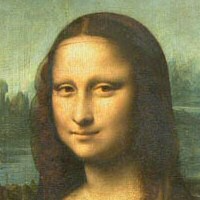

[0:00:02.215721] Iteration        1  ---  best_fitnesses [0.775104]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


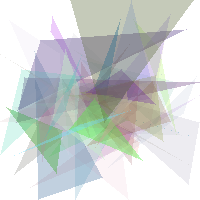

[0:00:05.691267] Iteration      100  ---  best_fitnesses [0.975308]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


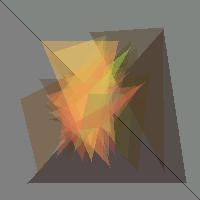

[0:00:08.033089] Iteration      200  ---  best_fitnesses [0.9815541]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


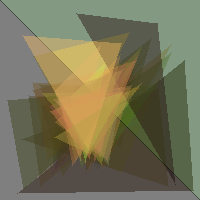

[0:00:10.270328] Iteration      300  ---  best_fitnesses [0.98386174]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


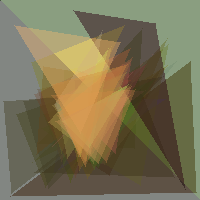

[0:00:12.483425] Iteration      400  ---  best_fitnesses [0.9854048]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


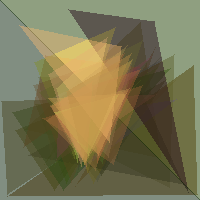

[0:00:14.710550] Iteration      500  ---  best_fitnesses [0.986637]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


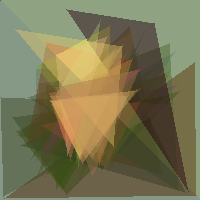

[0:00:16.915547] Iteration      600  ---  best_fitnesses [0.98860294]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


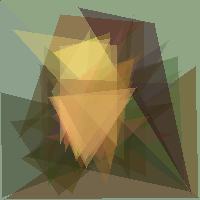

[0:00:19.113966] Iteration      700  ---  best_fitnesses [0.98957556]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


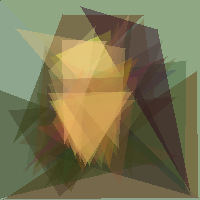

[0:00:21.334621] Iteration      800  ---  best_fitnesses [0.98988765]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


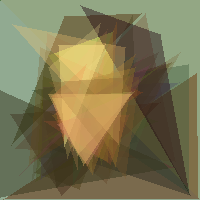

[0:00:23.542919] Iteration      900  ---  best_fitnesses [0.99030465]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


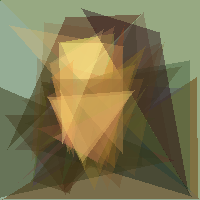

[0:00:25.740365] Iteration     1000  ---  best_fitnesses [0.99074674]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


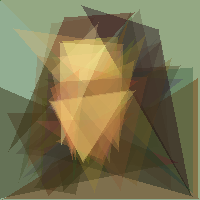

[0:00:27.953952] Iteration     1100  ---  best_fitnesses [0.98985976]


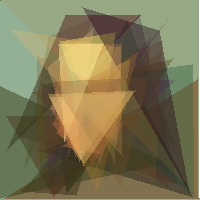

[0:00:30.146380] Iteration     1200  ---  best_fitnesses [0.99154663]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


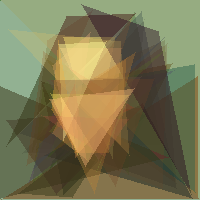

[0:00:32.357006] Iteration     1300  ---  best_fitnesses [0.991967]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


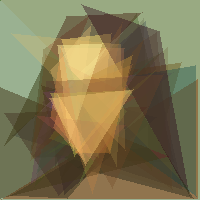

[0:00:34.564600] Iteration     1400  ---  best_fitnesses [0.9924874]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


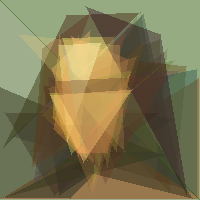

[0:00:36.758277] Iteration     1500  ---  best_fitnesses [0.99281573]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


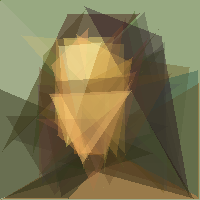

[0:00:38.995158] Iteration     1600  ---  best_fitnesses [0.993187]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


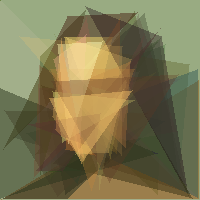

[0:00:41.260126] Iteration     1700  ---  best_fitnesses [0.99350196]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


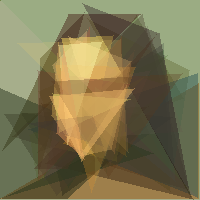

[0:00:43.511712] Iteration     1800  ---  best_fitnesses [0.9937734]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


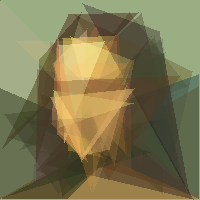

[0:00:45.729781] Iteration     1900  ---  best_fitnesses [0.99391]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


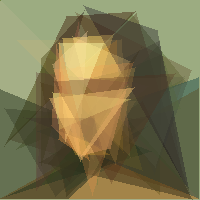

[0:00:47.928692] Iteration     2000  ---  best_fitnesses [0.9940815]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


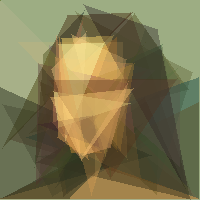

[0:00:50.126308] Iteration     2100  ---  best_fitnesses [0.99425745]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


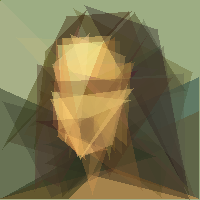

[0:00:52.323906] Iteration     2200  ---  best_fitnesses [0.9943038]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


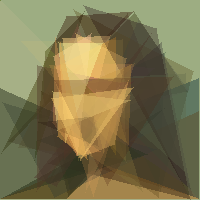

[0:00:54.514328] Iteration     2300  ---  best_fitnesses [0.9944652]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


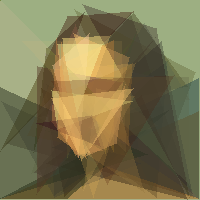

[0:00:56.722252] Iteration     2400  ---  best_fitnesses [0.99456173]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


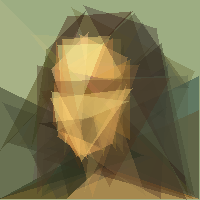

[0:00:58.913084] Iteration     2500  ---  best_fitnesses [0.99463606]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


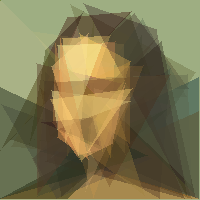

[0:01:01.126776] Iteration     2600  ---  best_fitnesses [0.99472684]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


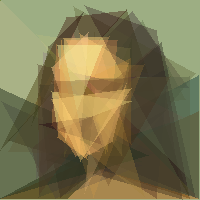

[0:01:03.341989] Iteration     2700  ---  best_fitnesses [0.9948371]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


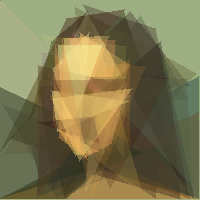

[0:01:05.520883] Iteration     2800  ---  best_fitnesses [0.994891]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


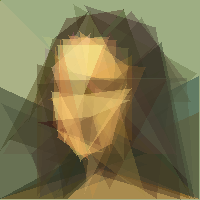

[0:01:07.717510] Iteration     2900  ---  best_fitnesses [0.99494106]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


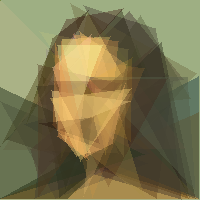

[0:01:09.897491] Iteration     3000  ---  best_fitnesses [0.9934404]


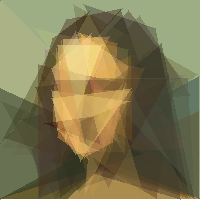

[0:01:12.088389] Iteration     3100  ---  best_fitnesses [0.99503636]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


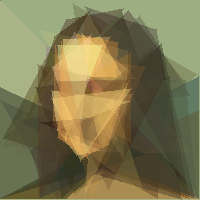

[0:01:14.285080] Iteration     3200  ---  best_fitnesses [0.9950389]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


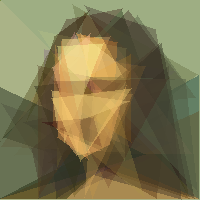

[0:01:16.494768] Iteration     3300  ---  best_fitnesses [0.9950805]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


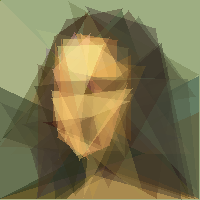

[0:01:18.695873] Iteration     3400  ---  best_fitnesses [0.99508584]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


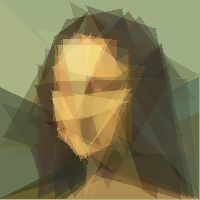

[0:01:20.882136] Iteration     3500  ---  best_fitnesses [0.9951071]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


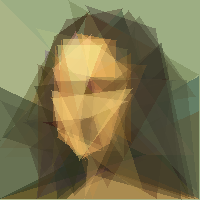

[0:01:23.094989] Iteration     3600  ---  best_fitnesses [0.9951228]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


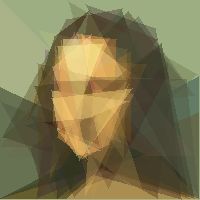

[0:01:25.301674] Iteration     3700  ---  best_fitnesses [0.99513483]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


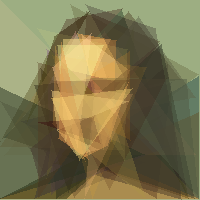

[0:01:27.505207] Iteration     3800  ---  best_fitnesses [0.99516004]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


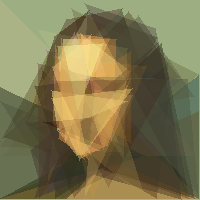

[0:01:29.703834] Iteration     3900  ---  best_fitnesses [0.9951636]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


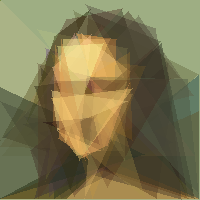

[0:01:31.883236] Iteration     4000  ---  best_fitnesses [0.9951707]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


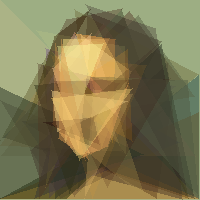

[0:01:34.069947] Iteration     4100  ---  best_fitnesses [0.99518794]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


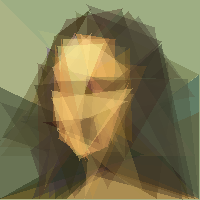

[0:01:36.274287] Iteration     4200  ---  best_fitnesses [0.9951921]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


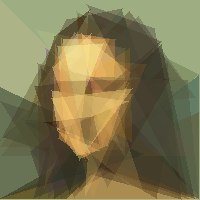

[0:01:38.472715] Iteration     4300  ---  best_fitnesses [0.9952241]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


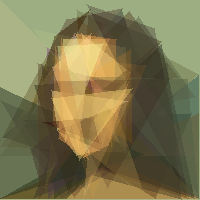

[0:01:40.682081] Iteration     4400  ---  best_fitnesses [0.99523526]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


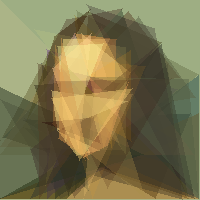

[0:01:42.880386] Iteration     4500  ---  best_fitnesses [0.99524343]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


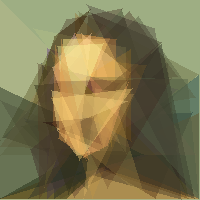

[0:01:45.057056] Iteration     4600  ---  best_fitnesses [0.99524325]


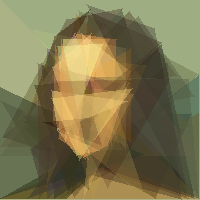

[0:01:47.219059] Iteration     4700  ---  best_fitnesses [0.9952567]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


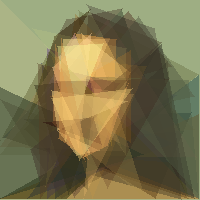

[0:01:49.404477] Iteration     4800  ---  best_fitnesses [0.99526334]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


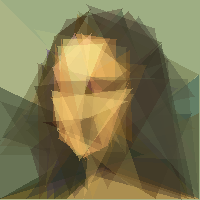

[0:01:51.674245] Iteration     4900  ---  best_fitnesses [0.9952666]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


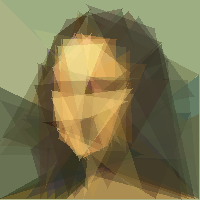

[0:01:53.926557] Iteration     5000  ---  best_fitnesses [0.9952706]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


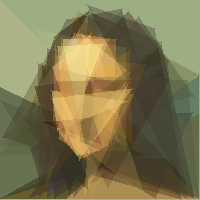

[0:01:56.218053] Iteration     5100  ---  best_fitnesses [0.9952676]


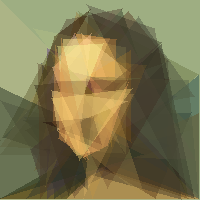

[0:01:58.432737] Iteration     5200  ---  best_fitnesses [0.9952717]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


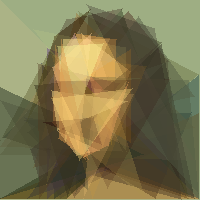

[0:02:00.663634] Iteration     5300  ---  best_fitnesses [0.99527395]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


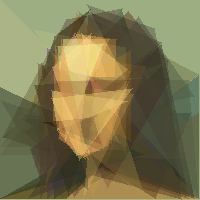

[0:02:02.860588] Iteration     5400  ---  best_fitnesses [0.9952757]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


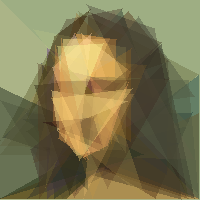

[0:02:05.068685] Iteration     5500  ---  best_fitnesses [0.9952757]


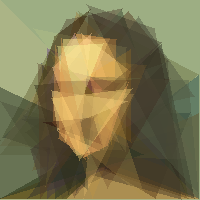

[0:02:07.255416] Iteration     5600  ---  best_fitnesses [0.9952796]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


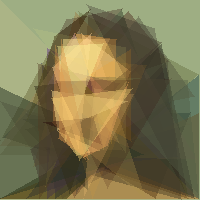

[0:02:09.462600] Iteration     5700  ---  best_fitnesses [0.99528056]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


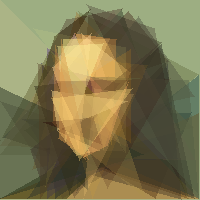

[0:02:11.679640] Iteration     5800  ---  best_fitnesses [0.9952832]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


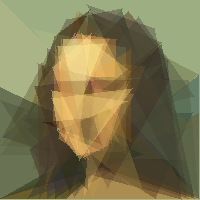

[0:02:13.873352] Iteration     5900  ---  best_fitnesses [0.99528307]


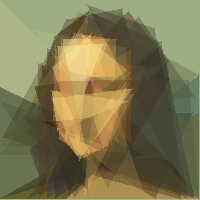

[0:02:16.063746] Iteration     6000  ---  best_fitnesses [0.99528563]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


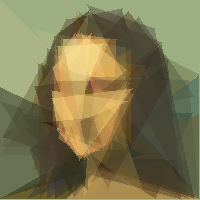

[0:02:18.265825] Iteration     6100  ---  best_fitnesses [0.9952834]


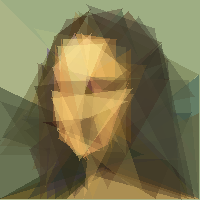

[0:02:20.446542] Iteration     6200  ---  best_fitnesses [0.99528617]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


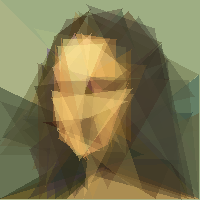

[0:02:22.648460] Iteration     6300  ---  best_fitnesses [0.99528843]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


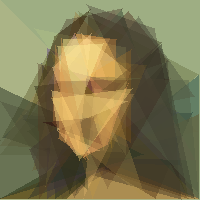

[0:02:24.850623] Iteration     6400  ---  best_fitnesses [0.99528795]


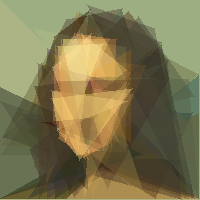

[0:02:27.021854] Iteration     6500  ---  best_fitnesses [0.9952894]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


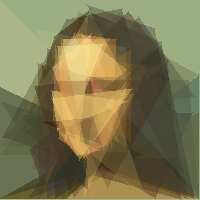

[0:02:29.244092] Iteration     6600  ---  best_fitnesses [0.9952894]


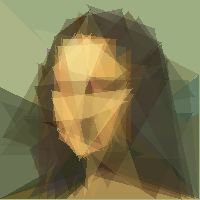

[0:02:31.456956] Iteration     6700  ---  best_fitnesses [0.99528867]


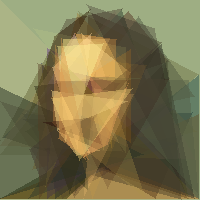

[0:02:33.642777] Iteration     6800  ---  best_fitnesses [0.99529046]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


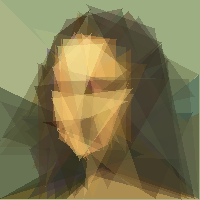

[0:02:35.863435] Iteration     6900  ---  best_fitnesses [0.99528986]


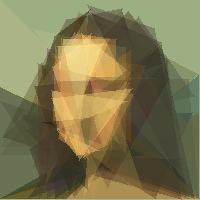

[0:02:38.037144] Iteration     7000  ---  best_fitnesses [0.99529165]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


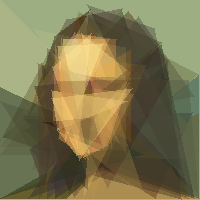

[0:02:40.256666] Iteration     7100  ---  best_fitnesses [0.99529034]


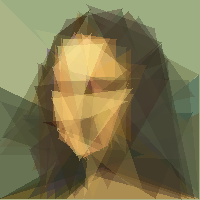

[0:02:42.465329] Iteration     7200  ---  best_fitnesses [0.9952926]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


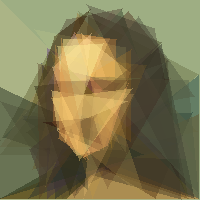

[0:02:44.717472] Iteration     7300  ---  best_fitnesses [0.99529237]


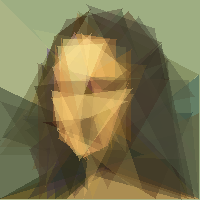

[0:02:46.962291] Iteration     7400  ---  best_fitnesses [0.99529016]


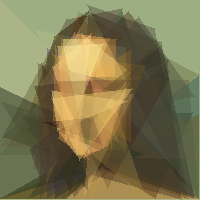

[0:02:49.182782] Iteration     7500  ---  best_fitnesses [0.9952938]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


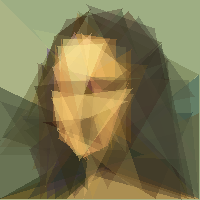

[0:02:51.416761] Iteration     7600  ---  best_fitnesses [0.99529165]


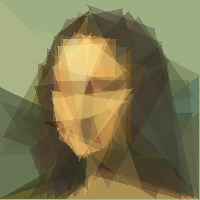

[0:02:53.661013] Iteration     7700  ---  best_fitnesses [0.9952924]


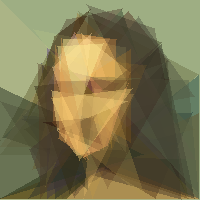

[0:02:55.873562] Iteration     7800  ---  best_fitnesses [0.99529356]


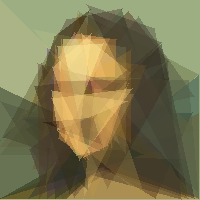

[0:02:58.071668] Iteration     7900  ---  best_fitnesses [0.9952939]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


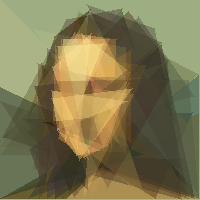

[0:03:00.314038] Iteration     8000  ---  best_fitnesses [0.9952946]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


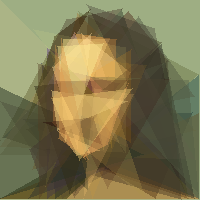

[0:03:02.526043] Iteration     8100  ---  best_fitnesses [0.99529344]


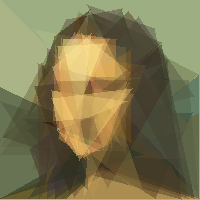

[0:03:04.765888] Iteration     8200  ---  best_fitnesses [0.995292]


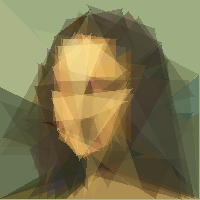

[0:03:06.955774] Iteration     8300  ---  best_fitnesses [0.9952917]


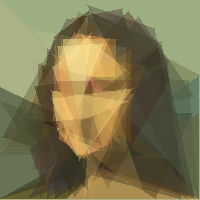

[0:03:09.219830] Iteration     8400  ---  best_fitnesses [0.99528927]


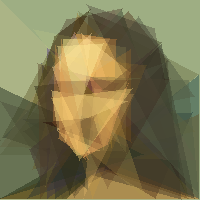

[0:03:11.419264] Iteration     8500  ---  best_fitnesses [0.99529314]


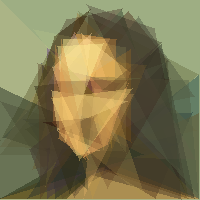

[0:03:13.630351] Iteration     8600  ---  best_fitnesses [0.99529326]


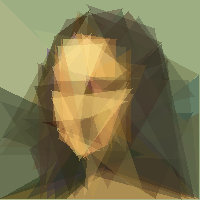

[0:03:15.866642] Iteration     8700  ---  best_fitnesses [0.99529064]


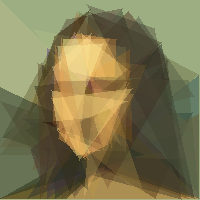

[0:03:18.113801] Iteration     8800  ---  best_fitnesses [0.9952939]


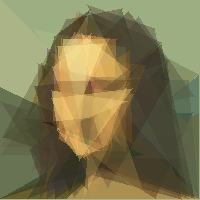

[0:03:20.284772] Iteration     8900  ---  best_fitnesses [0.99529326]


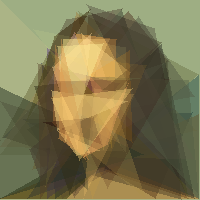

[0:03:22.469210] Iteration     9000  ---  best_fitnesses [0.99529386]


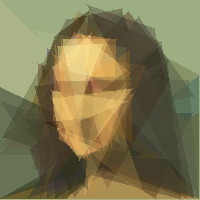

[0:03:24.714042] Iteration     9100  ---  best_fitnesses [0.9952931]


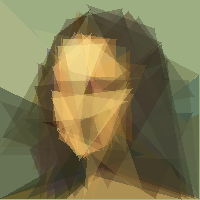

[0:03:26.963390] Iteration     9200  ---  best_fitnesses [0.9952915]


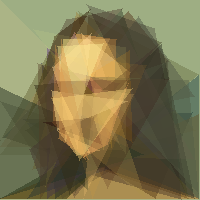

[0:03:29.145597] Iteration     9300  ---  best_fitnesses [0.9952919]


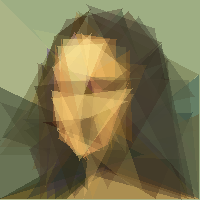

[0:03:31.342285] Iteration     9400  ---  best_fitnesses [0.9952941]


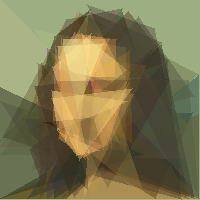

[0:03:33.580886] Iteration     9500  ---  best_fitnesses [0.9952954]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


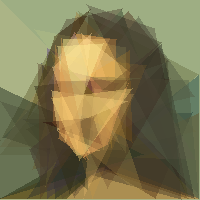

[0:03:35.858440] Iteration     9600  ---  best_fitnesses [0.99529445]


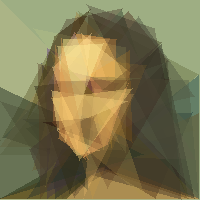

[0:03:38.066345] Iteration     9700  ---  best_fitnesses [0.995293]


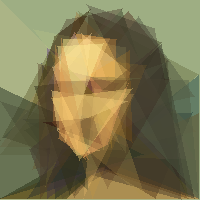

[0:03:40.322057] Iteration     9800  ---  best_fitnesses [0.99529314]


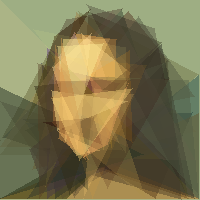

[0:03:42.504256] Iteration     9900  ---  best_fitnesses [0.9952946]


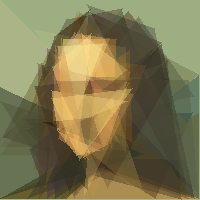

[0:03:44.695175] Iteration    10000  ---  best_fitnesses [0.9952934]


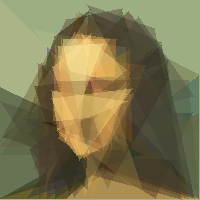

Target Image:


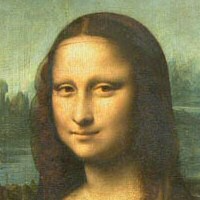

[0:00:00.979383] Iteration        1  ---  best_fitnesses [0.775104]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


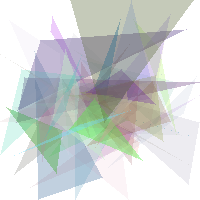

[0:00:03.621964] Iteration      100  ---  best_fitnesses [0.975308]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


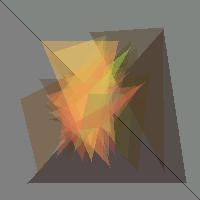

[0:00:05.855317] Iteration      200  ---  best_fitnesses [0.9815541]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


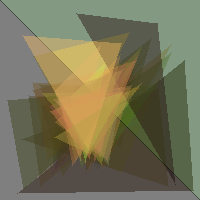

[0:00:08.089684] Iteration      300  ---  best_fitnesses [0.98386174]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


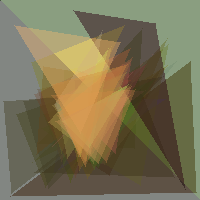

[0:00:10.306672] Iteration      400  ---  best_fitnesses [0.9854048]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


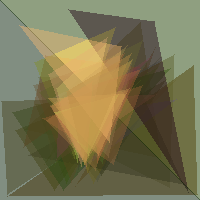

[0:00:12.566326] Iteration      500  ---  best_fitnesses [0.986637]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


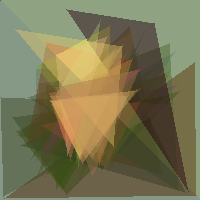

[0:00:14.873944] Iteration      600  ---  best_fitnesses [0.98860294]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


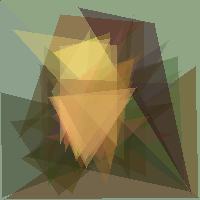

[0:00:17.178210] Iteration      700  ---  best_fitnesses [0.98957556]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


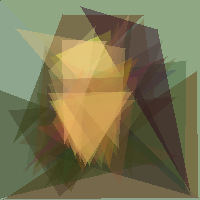

[0:00:19.400105] Iteration      800  ---  best_fitnesses [0.98988765]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


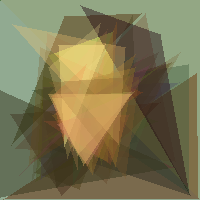

[0:00:21.628392] Iteration      900  ---  best_fitnesses [0.99030465]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


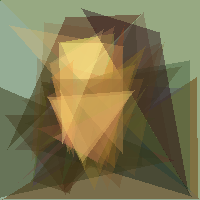

[0:00:23.855389] Iteration     1000  ---  best_fitnesses [0.99074674]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


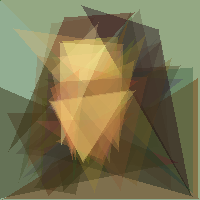

[0:00:26.134032] Iteration     1100  ---  best_fitnesses [0.98985976]


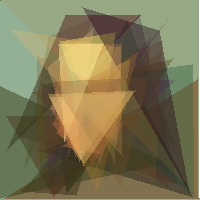

[0:00:28.396659] Iteration     1200  ---  best_fitnesses [0.99154663]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


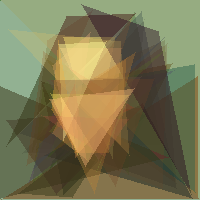

[0:00:30.644811] Iteration     1300  ---  best_fitnesses [0.991967]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


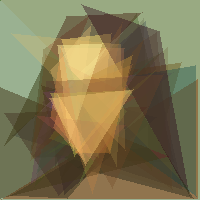

[0:00:32.925777] Iteration     1400  ---  best_fitnesses [0.9924874]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


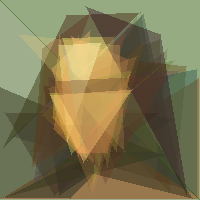

[0:00:35.150210] Iteration     1500  ---  best_fitnesses [0.99281573]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


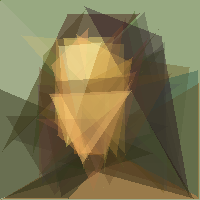

[0:00:37.402585] Iteration     1600  ---  best_fitnesses [0.993187]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


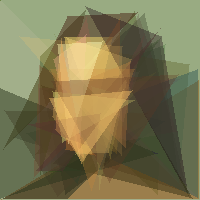

[0:00:39.666669] Iteration     1700  ---  best_fitnesses [0.99350196]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


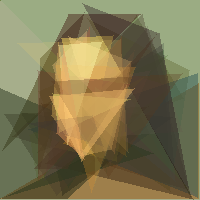

[0:00:41.920712] Iteration     1800  ---  best_fitnesses [0.9937734]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


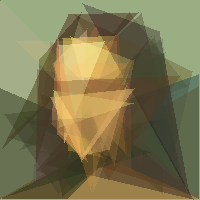

[0:00:44.171729] Iteration     1900  ---  best_fitnesses [0.99391]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


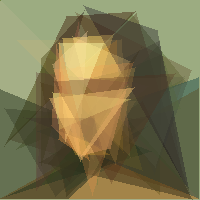

[0:00:46.412523] Iteration     2000  ---  best_fitnesses [0.9940815]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


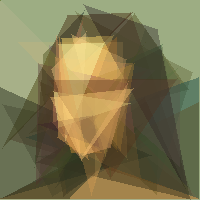

[0:00:48.635805] Iteration     2100  ---  best_fitnesses [0.99425745]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


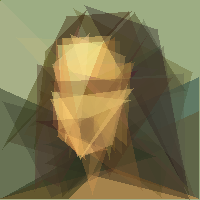

[0:00:50.852777] Iteration     2200  ---  best_fitnesses [0.9943038]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


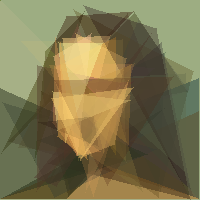

[0:00:53.074506] Iteration     2300  ---  best_fitnesses [0.9944652]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


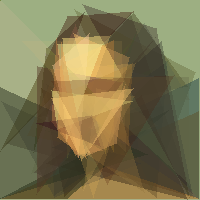

[0:00:55.281757] Iteration     2400  ---  best_fitnesses [0.99456173]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


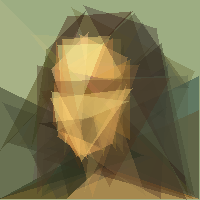

[0:00:57.519697] Iteration     2500  ---  best_fitnesses [0.99463606]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


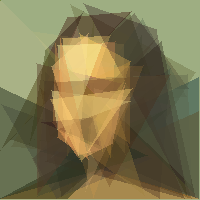

[0:00:59.726636] Iteration     2600  ---  best_fitnesses [0.99472684]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


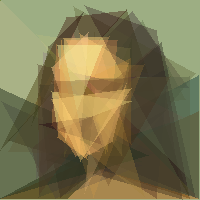

[0:01:01.989696] Iteration     2700  ---  best_fitnesses [0.9948371]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


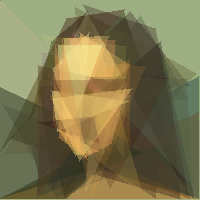

[0:01:04.198655] Iteration     2800  ---  best_fitnesses [0.994891]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


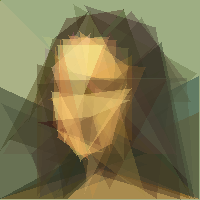

[0:01:06.424237] Iteration     2900  ---  best_fitnesses [0.99494106]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


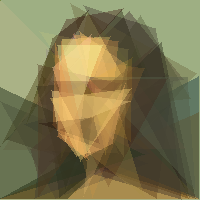

[0:01:08.639732] Iteration     3000  ---  best_fitnesses [0.9934404]


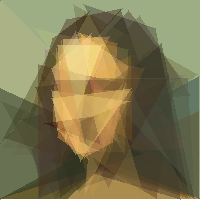

[0:01:10.837759] Iteration     3100  ---  best_fitnesses [0.99503636]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


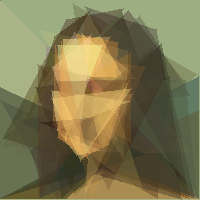

[0:01:13.078925] Iteration     3200  ---  best_fitnesses [0.9950389]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


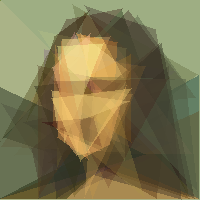

[0:01:15.295339] Iteration     3300  ---  best_fitnesses [0.9950805]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


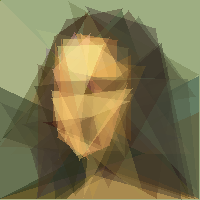

[0:01:17.497198] Iteration     3400  ---  best_fitnesses [0.99508584]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


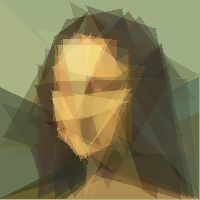

[0:01:19.713267] Iteration     3500  ---  best_fitnesses [0.9951071]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


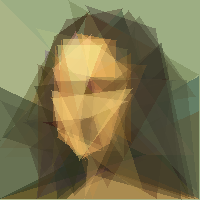

[0:01:21.938421] Iteration     3600  ---  best_fitnesses [0.9951228]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


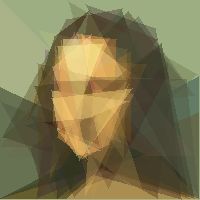

[0:01:24.156361] Iteration     3700  ---  best_fitnesses [0.99513483]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


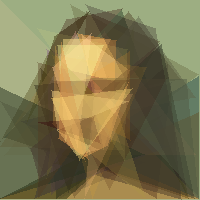

[0:01:26.371314] Iteration     3800  ---  best_fitnesses [0.99516004]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


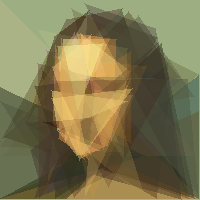

[0:01:28.591755] Iteration     3900  ---  best_fitnesses [0.9951636]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


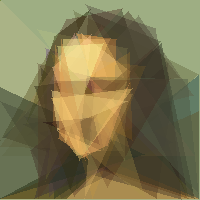

[0:01:30.798689] Iteration     4000  ---  best_fitnesses [0.9951707]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


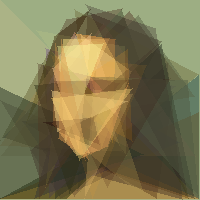

[0:01:33.007309] Iteration     4100  ---  best_fitnesses [0.99518794]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


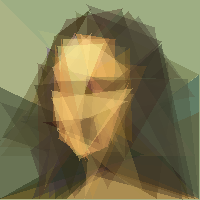

[0:01:35.215586] Iteration     4200  ---  best_fitnesses [0.9951921]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


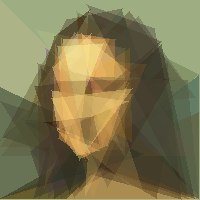

[0:01:37.438086] Iteration     4300  ---  best_fitnesses [0.9952241]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


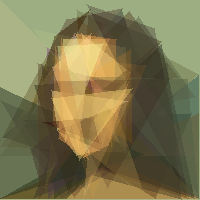

[0:01:39.653587] Iteration     4400  ---  best_fitnesses [0.99523526]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


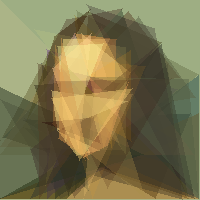

[0:01:41.892212] Iteration     4500  ---  best_fitnesses [0.99524343]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


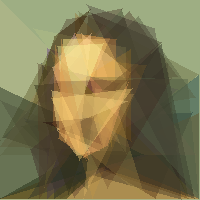

[0:01:44.120514] Iteration     4600  ---  best_fitnesses [0.99524325]


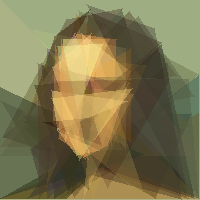

[0:01:46.331696] Iteration     4700  ---  best_fitnesses [0.9952567]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


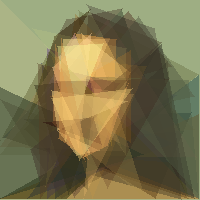

[0:01:48.550744] Iteration     4800  ---  best_fitnesses [0.99526334]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


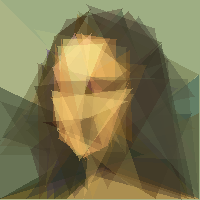

[0:01:50.782828] Iteration     4900  ---  best_fitnesses [0.9952666]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


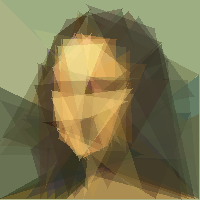

[0:01:53.188522] Iteration     5000  ---  best_fitnesses [0.9952706]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


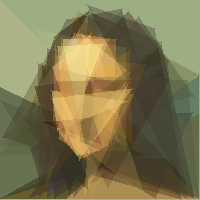

[0:01:55.433019] Iteration     5100  ---  best_fitnesses [0.9952676]


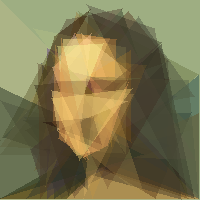

[0:01:57.670893] Iteration     5200  ---  best_fitnesses [0.9952717]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


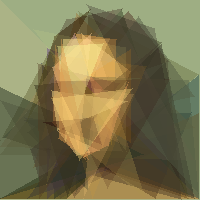

[0:01:59.881595] Iteration     5300  ---  best_fitnesses [0.99527395]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


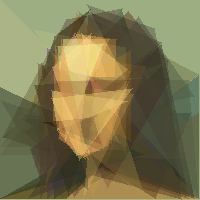

[0:02:02.113420] Iteration     5400  ---  best_fitnesses [0.9952757]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


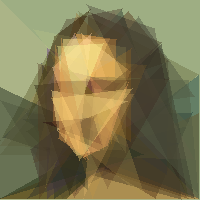

[0:02:04.363030] Iteration     5500  ---  best_fitnesses [0.9952757]


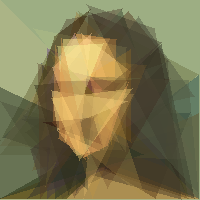

[0:02:06.568930] Iteration     5600  ---  best_fitnesses [0.9952796]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


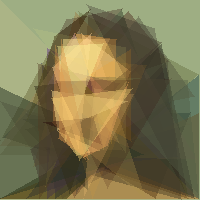

[0:02:08.777290] Iteration     5700  ---  best_fitnesses [0.99528056]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


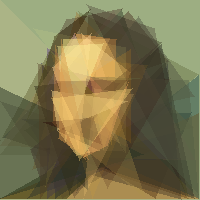

[0:02:10.989772] Iteration     5800  ---  best_fitnesses [0.9952832]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


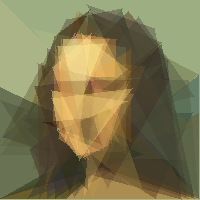

[0:02:13.216529] Iteration     5900  ---  best_fitnesses [0.99528307]


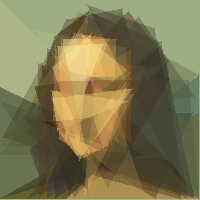

[0:02:15.407136] Iteration     6000  ---  best_fitnesses [0.99528563]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


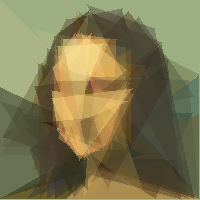

[0:02:17.658481] Iteration     6100  ---  best_fitnesses [0.9952834]


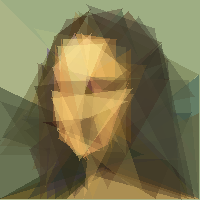

[0:02:19.862520] Iteration     6200  ---  best_fitnesses [0.99528617]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


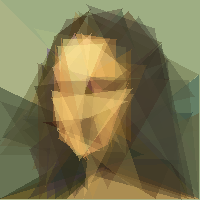

[0:02:22.127290] Iteration     6300  ---  best_fitnesses [0.99528843]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


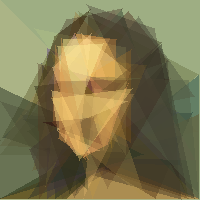

[0:02:24.323436] Iteration     6400  ---  best_fitnesses [0.99528795]


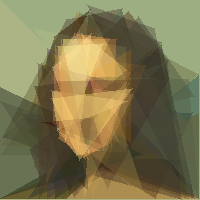

[0:02:26.512341] Iteration     6500  ---  best_fitnesses [0.9952894]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


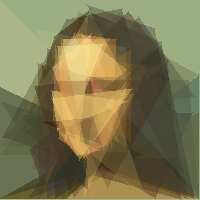

[0:02:28.729417] Iteration     6600  ---  best_fitnesses [0.9952894]


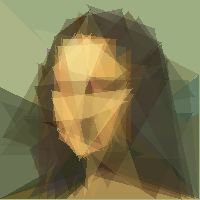

[0:02:30.934942] Iteration     6700  ---  best_fitnesses [0.99528867]


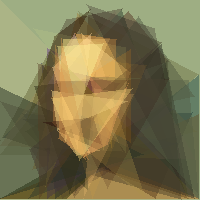

[0:02:33.140601] Iteration     6800  ---  best_fitnesses [0.99529046]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


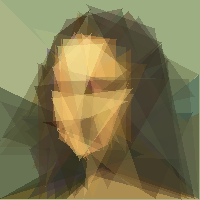

[0:02:35.362189] Iteration     6900  ---  best_fitnesses [0.99528986]


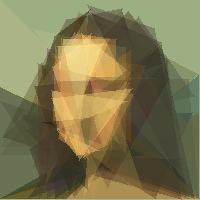

[0:02:37.529697] Iteration     7000  ---  best_fitnesses [0.99529165]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


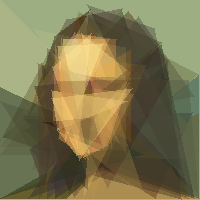

[0:02:39.728289] Iteration     7100  ---  best_fitnesses [0.99529034]


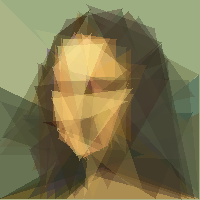

[0:02:41.948303] Iteration     7200  ---  best_fitnesses [0.9952926]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


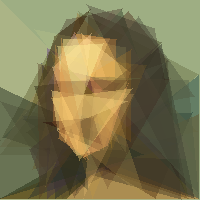

[0:02:44.166349] Iteration     7300  ---  best_fitnesses [0.99529237]


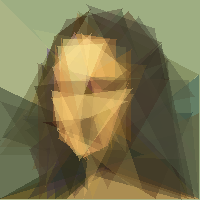

[0:02:46.348410] Iteration     7400  ---  best_fitnesses [0.99529016]


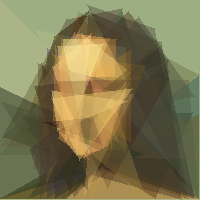

[0:02:48.539272] Iteration     7500  ---  best_fitnesses [0.9952938]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


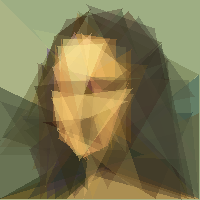

[0:02:50.735692] Iteration     7600  ---  best_fitnesses [0.99529165]


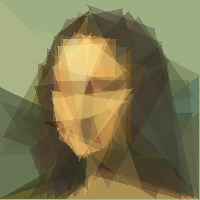

[0:02:52.890503] Iteration     7700  ---  best_fitnesses [0.9952924]


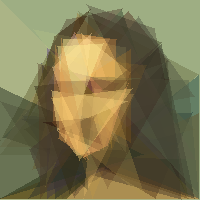

[0:02:55.043695] Iteration     7800  ---  best_fitnesses [0.99529356]


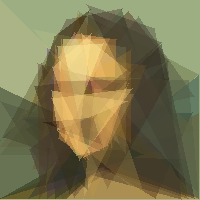

[0:02:57.280495] Iteration     7900  ---  best_fitnesses [0.9952939]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


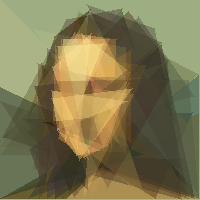

[0:02:59.453004] Iteration     8000  ---  best_fitnesses [0.9952946]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


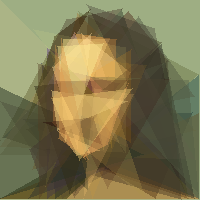

[0:03:01.659796] Iteration     8100  ---  best_fitnesses [0.99529344]


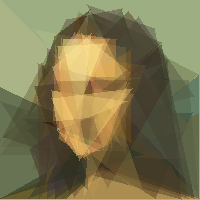

[0:03:03.854940] Iteration     8200  ---  best_fitnesses [0.995292]


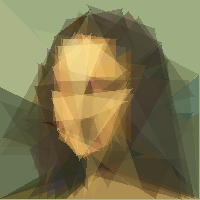

[0:03:06.020432] Iteration     8300  ---  best_fitnesses [0.9952917]


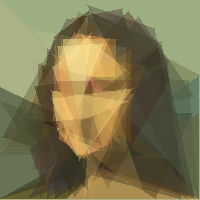

[0:03:08.209589] Iteration     8400  ---  best_fitnesses [0.99528927]


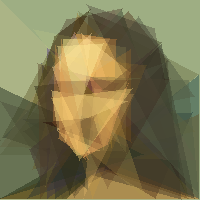

[0:03:10.452800] Iteration     8500  ---  best_fitnesses [0.99529314]


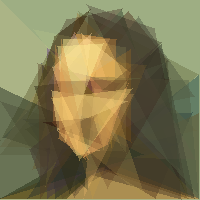

[0:03:12.637020] Iteration     8600  ---  best_fitnesses [0.99529326]


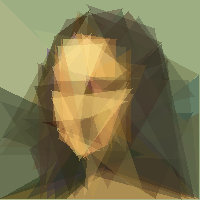

[0:03:14.799363] Iteration     8700  ---  best_fitnesses [0.99529064]


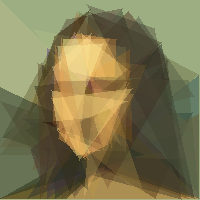

[0:03:16.979491] Iteration     8800  ---  best_fitnesses [0.9952939]


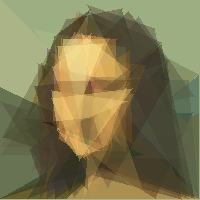

[0:03:19.161596] Iteration     8900  ---  best_fitnesses [0.99529326]


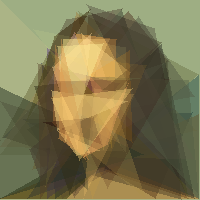

[0:03:21.352574] Iteration     9000  ---  best_fitnesses [0.99529386]


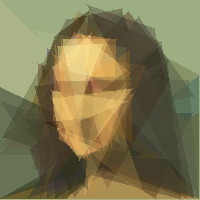

[0:03:23.511756] Iteration     9100  ---  best_fitnesses [0.9952931]


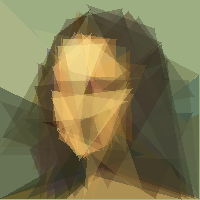

[0:03:25.720137] Iteration     9200  ---  best_fitnesses [0.9952915]


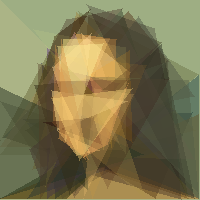

[0:03:27.948222] Iteration     9300  ---  best_fitnesses [0.9952919]


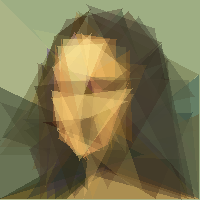

[0:03:30.136520] Iteration     9400  ---  best_fitnesses [0.9952941]


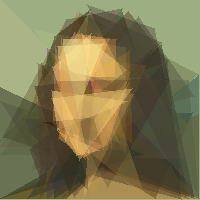

[0:03:32.359486] Iteration     9500  ---  best_fitnesses [0.9952954]
		 best canvas saved to `AbstractPainting01_best_canvas.png` and `AbstractPainting01_best_canvas.svg`


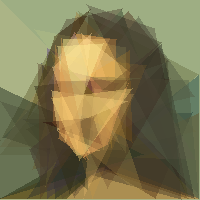

[0:03:34.561340] Iteration     9600  ---  best_fitnesses [0.99529445]


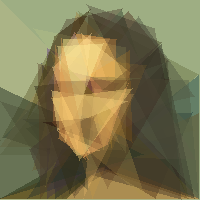

[0:03:36.740652] Iteration     9700  ---  best_fitnesses [0.995293]


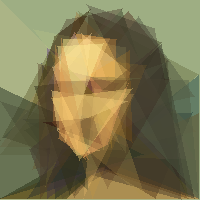

[0:03:38.939113] Iteration     9800  ---  best_fitnesses [0.99529314]


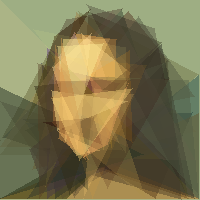

[0:03:41.125663] Iteration     9900  ---  best_fitnesses [0.9952946]


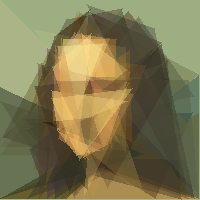

[0:03:43.323808] Iteration    10000  ---  best_fitnesses [0.9952934]


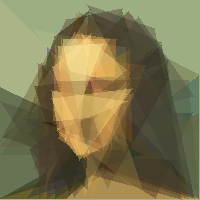

In [ ]:
main_loop()

In [ ]:
# make a gif

import glob
import IPython

frames = []
imgs = glob.glob("AbstractPainting01_canvas_record.*.png")
imgs.sort()
for file in imgs:
  new_frame = Image.open(file)
  frames.append(new_frame)
frames[0].save('AbstractPainting01_final.gif', save_all=True, append_images=frames, optimize=True, duration=200, loop=0)

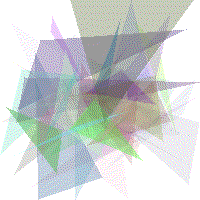

In [ ]:
IPython.display.Image('AbstractPainting01_final.gif', format='png')